<a href="https://colab.research.google.com/github/ghowsigan/ghowsi21/blob/main/annual%20house%20price%20and%20sales%20report%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#data cleaning
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from google.colab import files

# Load dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/hdata.csv"  # Change this if needed
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hdata.csv")


# Fill missing numerical values with median
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))

# Fill missing categorical values with most frequent value
cat_cols = df.select_dtypes(include=['object']).columns
imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = imputer.fit_transform(df[cat_cols])

# Convert all string values to lowercase using DataFrame.map
for col in cat_cols:
    df[col] = df[col].map(lambda x: x.lower() if isinstance(x, str) else x)

# Encode categorical variables
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# Drop ID column
df.drop(columns=["Id"], inplace=True)

# Save cleaned dataset
df.to_csv("cleaned_hdata.csv", index=False)

print("Dataset cleaned and saved as 'cleaned_hdata.csv'")
print(df.isnull().sum())


df.to_csv("cleaned_hdata.csv", index=False)  # Save locally in Colab
files.download("cleaned_hdata.csv")  # Download to your computer


Dataset cleaned and saved as 'cleaned_hdata.csv'
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# Import necessary libraries
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/cleaned_hdata.csv")

# Fill missing numerical values with median
num_cols = df.select_dtypes(include=['number']).columns.tolist()

# Ensure "SalePrice" exists before removing it
if "SalePrice" in num_cols:
    num_cols.remove("SalePrice")

imputer_num = SimpleImputer(strategy="median")
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# Check if there are categorical columns left
cat_cols = df.select_dtypes(include=['object']).columns

if len(cat_cols) > 0:
    # Fill missing categorical values with most frequent value
    imputer_cat = SimpleImputer(strategy="most_frequent")
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

    # Apply OneHotEncoder for categorical encoding
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
    encoded_cats = encoder.fit_transform(df[cat_cols])
    cat_feature_names = encoder.get_feature_names_out(cat_cols)
    df_encoded = pd.DataFrame(encoded_cats, columns=cat_feature_names)

    # Drop original categorical columns and merge with the encoded ones
    df = df.drop(columns=cat_cols)
    df = pd.concat([df, df_encoded], axis=1)

# Apply feature scaling (Standardization) only to numerical features (excluding "SalePrice")
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Define features and target variable
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning with RandomizedSearchCV (faster)
xgb_model = xgb.XGBRegressor()

param_dist = {
    'n_estimators': [300, 500, 700],  # Fewer values for faster tuning
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6],  # Limited depth to prevent overfitting
    'subsample': [0.8, 1.0]
}

random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    n_jobs=-1, random_state=42
)

random_search.fit(X_train, y_train)

# Get the best model
best_xgb = random_search.best_estimator_

# Make predictions
y_pred = best_xgb.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"MAE : {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Best Parameters: {random_search.best_params_}")

# Save the trained model
joblib.dump(best_xgb, "xgboost_house_price.pkl")
print("Model saved as 'xgboost_house_price.pkl'")



MAE : 15402.39
MSE: 605710784.00
R² Score: 0.9210
Best Parameters: {'subsample': 0.8, 'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.05}
Model saved as 'xgboost_house_price.pkl'


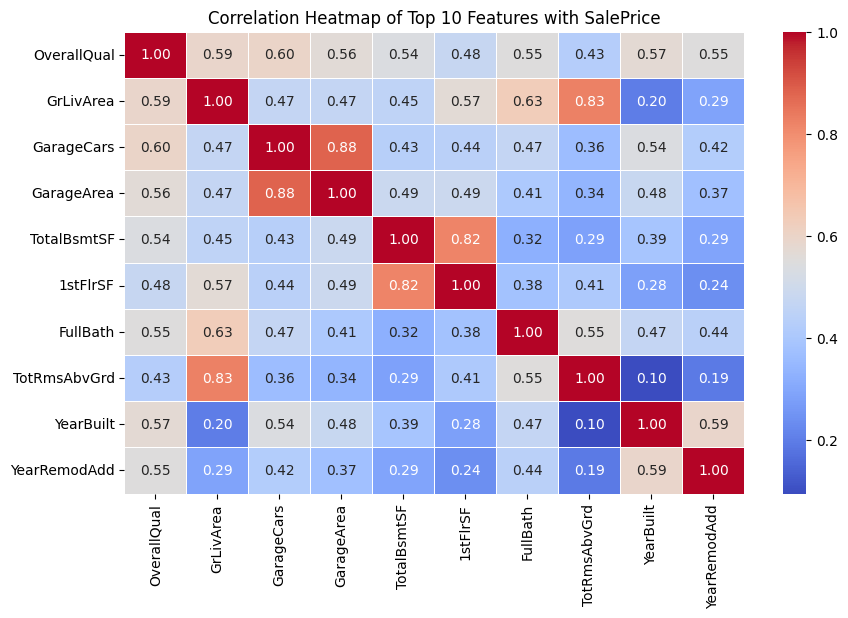

Error in feature importance plot: Length of values (79) does not match length of index (10)


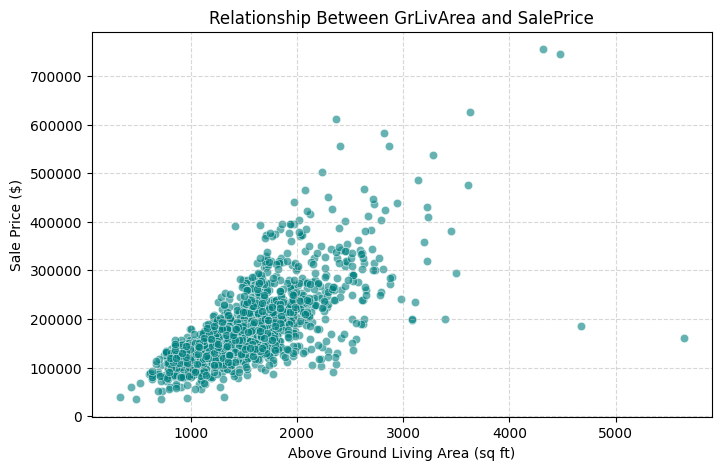

<ipython-input-37-3550d55c12df>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="OverallQual", y="SalePrice", data=df, palette="viridis")


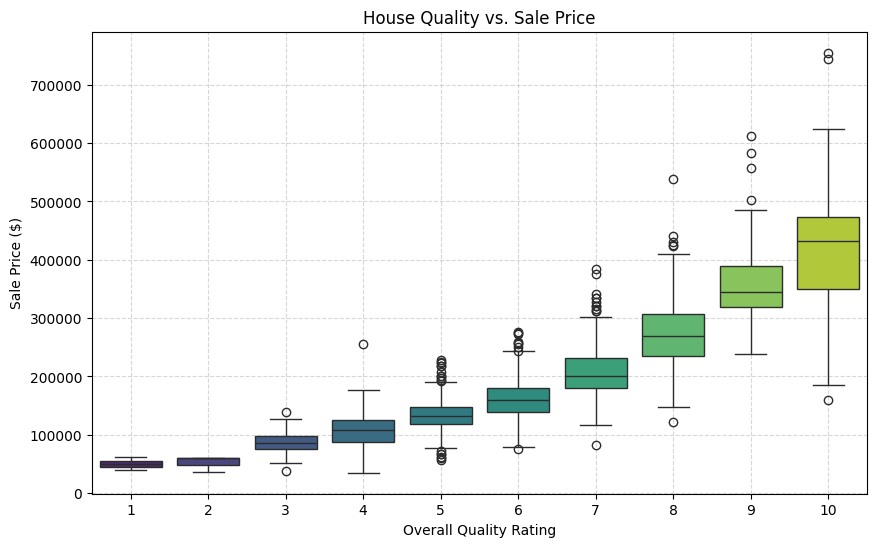


Top 10 Features Correlated with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

Top 10 Most Important Features from XGBoost:
OverallQual     0.296355
GarageCars      0.109692
Condition2      0.091861
FullBath        0.071805
LowQualFinSF    0.046443
GrLivArea       0.041904
KitchenQual     0.035769
GarageFinish    0.025135
BsmtQual        0.020887
ExterQual       0.016775
dtype: float32


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure dataset is loaded properly
df = pd.read_csv("/content/cleaned_hdata.csv")

# Drop rows with missing SalePrice (if any)
df = df.dropna(subset=["SalePrice"])

# Compute correlation with SalePrice
correlation = df.corr()["SalePrice"].sort_values(ascending=False)

# Select the top 10 most correlated features (excluding SalePrice itself)
top_features = correlation.index[1:11] if len(correlation) > 10 else correlation.index[1:]

# Plot correlation heatmap (only if top_features exist)
if len(top_features) > 1:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df[top_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap of Top 10 Features with SalePrice")
    plt.show()
else:
    print("Warning: Not enough numerical features for correlation heatmap.")

# Ensure the trained XGBoost model exists
try:
    # Use X_train if defined; otherwise, extract feature names from df
    feature_columns = X_train.columns if 'X_train' in locals() else df.drop("SalePrice", axis=1).columns
    feature_importance = pd.Series(best_xgb.feature_importances_, index=feature_columns)

    # Select top 10 important features
    feature_importance = feature_importance.sort_values(ascending=False)[:10]

    # Plot feature importance
    plt.figure(figsize=(10, 5))
    feature_importance.plot(kind="bar", color="royalblue")
    plt.title("Top 10 Most Important Features Influencing House Prices")
    plt.ylabel("Importance Score")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
except Exception as e:
    print(f"Error in feature importance plot: {e}")

# Scatter plot: Most correlated feature (GrLivArea) vs. SalePrice
if "GrLivArea" in df.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df["GrLivArea"], y=df["SalePrice"], alpha=0.6, color="teal")
    plt.xlabel("Above Ground Living Area (sq ft)")
    plt.ylabel("Sale Price ($)")
    plt.title("Relationship Between GrLivArea and SalePrice")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
else:
    print("Warning: 'GrLivArea' column is missing in the dataset.")

# Ensure OverallQual exists and convert to integer
if "OverallQual" in df.columns:
    df["OverallQual"] = df["OverallQual"].astype(int)

    # Box plot: OverallQual vs. SalePrice
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="OverallQual", y="SalePrice", data=df, palette="viridis")

    plt.xlabel("Overall Quality Rating")
    plt.ylabel("Sale Price ($)")
    plt.title("House Quality vs. Sale Price")

    plt.xticks(rotation=0)  # Ensure x-axis labels are clear
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
else:
    print("Warning: 'OverallQual' column is missing in the dataset.")

# Display top correlations & feature importance scores
print("\nTop 10 Features Correlated with SalePrice:")
print(correlation.head(11))  # Include SalePrice for reference

print("\nTop 10 Most Important Features from XGBoost:")
print(feature_importance)
